# Desafío 1: Determinantes del ingreso

### Nombre: Juan Oyarce G.
### Profesor: Gabriel Tamayo
### Curso: G2


## Hito 1: Aspectos preeliminares, Aspectos computacionales

### 1.1.- Análisis de los enunciados:  Descripción del problema

- El problema consiste en generar un modelo que a partir de variables socioeconómicas permita predecir si un individuo obtendrá un ingreso mayor a 50 k o menor a 50k.
 

### 1.2.- Análisis de los enunciados:   Objetivo de la modelación

- Desarrollar un modelo basado en regresión logística que permita clasificar en clases binarias la ocurrencia del factor, es decir aquellos cuyos ingresos son superiores o inferiores a 50 k

### 1.3.- Análisis de los enunciados:   Metodología de análisis

- La metodología consistirá en hacer una limpieza del data set, visualizar valores perdidos, recodificar las variables según instrucciones y generar variables dummies en aquellas que sea necesario, luego se procederá a visualizar histogramas de frecuencias para variables continuas y graficos de barras para variables categóricas, posteriormente se harán scaterr plot, pruebas de normalidad y mapas de correlacion, luego se plantearan los modelos econométricos saturados con todas las variables predictoras, éstos modelos se depurarán con aquellas estadísticamente significativas (pvalue<0.05), se desarrollará otro modelo y se generará un modelo de machine learning de regresión logística.

### 1.4.- Análisis de los enunciados:   Evaluación de los resultados

- Para evaluar los resultados, se evaluarán las predicciones de 3 modelos normalizados y con/sin intercepto, se evaluará la matriz de confusión, la precisión, la sensibilidad, f1, las curvas y coeficientes ROC, con éstas métricas se determinará cuál es el mejor modelo.

### 1.5.- Aspectos computacionales: Preparación del entorno

In [1]:
# importación de las librerías tradicionales de pandas, numpys, statsmodels, scipy, seaborn y matplotlib
import numpy as np
import pandas as pd
pd.options.display.max_columns = None #instrucción para que muestre todas las columnas del dataframe sin abreviarlas
pd.options.display.max_rows = 100 #instrucción para que muestre  n  las filas del dataframe sin abreviarlas
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import factor_analyzer as factor
import missingno as msngo
import warnings
warnings.filterwarnings("ignore")

# funciones propias

from functiones  import descriptives_plot

# Librerías de sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# Gráficos estilo seaborn
plt.style.use('seaborn')

# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos

- La inspección preeliminar no arroja datos perdidos, por lo tanto al inspeccionar los datos perdidos están recodificados como'?', hay dos maneras de resolver este problema, o reemplazamos los valores'?'  con la función de Pandas replace  y na de Numpy (df.replace("?", np.nan)) o le asignamos una lista previa de los valores perdidos al momento de cargar el dataset, está práctica se recomienda cuando ya se conoce el dataset, emplearemos éste método.

In [2]:
missing_values=["?"]     #valores perdidos adicionales
df= pd.read_csv("income-db.csv", na_values = missing_values)
df.shape

(48842, 15)

In [3]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


### 1.6.- Aspectos computacionales: Limpieza del dataset y recodificación de variables

In [4]:
# visualización  y tratamiento de datos perdidos

In [5]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

<Figure size 288x288 with 0 Axes>

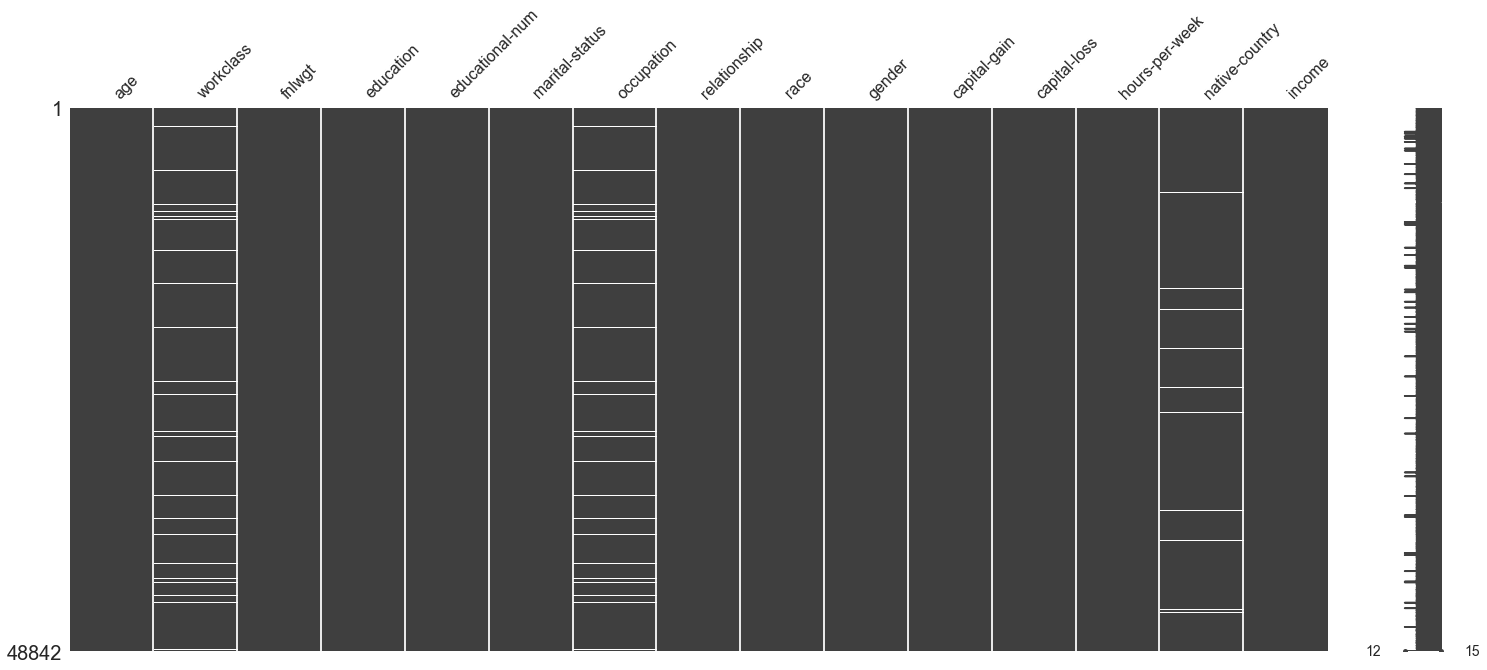

In [6]:
plt.figure(figsize=(4,4))
msngo.matrix(df);

In [7]:
df2=df.dropna()
df2.shape

(45222, 15)

In [8]:
print ("La cantidad de registros eliminados serán:  ", df.shape[0]-df2.shape[0])
print ("El Porcentaje de registros eliminados serán:  ", round(((df.shape[0]-df2.shape[0])/df.shape[0])*100,3), "%" )


La cantidad de registros eliminados serán:   3620
El Porcentaje de registros eliminados serán:   7.412 %


- Para el tratamiento de datos perdidos, se puede considerar rellenar éstos valores con estadísticos descriptivos como la media o la moda, pero dada la extensión del data set (casí 49000 datos), se puede apreciar que los datos perdidos representan el 7.4 % del dataset total, por lo tanto es factible eliminar los registros completos, sin alterar demasiado la distribución de la muestra.

In [9]:
df=df2
df.shape

(45222, 15)

In [10]:
# Recodificación de variables categóricas

In [11]:
df['occupation'].unique() # para saber que categorías existen

array(['Machine-op-inspct', 'Farming-fishing', 'Protective-serv',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [12]:
#recodificación de 'occupation'

df['occupation']=np.where(df['occupation']=='Prof-specialty','white_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Exec-managerial','white_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Adm-clerical','white_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Sales','white_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Tech-support','white_collar',df['occupation'])   

df['occupation']=np.where(df['occupation']=='Craft-repair','blue_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Machine-op-inspct','blue_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Transport-moving','blue_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Handlers-cleaners','blue_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Farming-fishing','blue_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Protective-serv','blue_collar',df['occupation'])   
df['occupation']=np.where(df['occupation']=='Priv-house-serv','blue_collar',df['occupation']) 

df['occupation']=np.where(df['occupation']=='Armed-Forces','others',df['occupation']) 
df['occupation']=np.where(df['occupation']=='Other-service','others',df['occupation']) 

In [13]:
df['occupation'].value_counts('%')

white_collar    0.538676
blue_collar     0.354695
others          0.106630
Name: occupation, dtype: float64

In [14]:
df.rename(columns=lambda x: x.replace('occupation', 'collars'), inplace=True) #  renombrar

In [15]:
df['collars'].value_counts('%')

white_collar    0.538676
blue_collar     0.354695
others          0.106630
Name: collars, dtype: float64

In [16]:
df['workclass'].unique()

array(['Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

In [17]:
df['workclass'].value_counts('%')

Private             0.736522
Self-emp-not-inc    0.083941
Local-gov           0.068551
State-gov           0.043032
Self-emp-inc        0.036398
Federal-gov         0.031091
Without-pay         0.000464
Name: workclass, dtype: float64

In [18]:
#recodificación de 'workclass'

df['workclass']=np.where(df['workclass']=='Federal-gov','federal_gov',df['workclass']) 

df['workclass']=np.where(df['workclass']=='State-gov','state_level_gov',df['workclass'])  
df['workclass']=np.where(df['workclass']=='Local-gov','state_level_gov',df['workclass'])  

df['workclass']=np.where(df['workclass']=='Self-emp-inc','self_employed',df['workclass'])
df['workclass']=np.where(df['workclass']=='Self-emp-not-inc','self_employed',df['workclass'])

df['workclass']=np.where(df['workclass']=='Without-pay','unemployed',df['workclass'])

df['workclass']=np.where(df['workclass']=='Private','private',df['workclass'])

In [19]:
df['workclass'].value_counts('%')

private            0.736522
self_employed      0.120340
state_level_gov    0.111583
federal_gov        0.031091
unemployed         0.000464
Name: workclass, dtype: float64

In [20]:
df.rename(columns=lambda x: x.replace('workclass', 'workclass_recod'), inplace=True) #  renombrar

In [21]:
df['workclass_recod'].value_counts('%')

private            0.736522
self_employed      0.120340
state_level_gov    0.111583
federal_gov        0.031091
unemployed         0.000464
Name: workclass_recod, dtype: float64

In [22]:
df['education'].value_counts('%')

HS-grad         0.326898
Some-college    0.218898
Bachelors       0.167396
Masters         0.055592
Assoc-voc       0.043320
11th            0.035801
Assoc-acdm      0.033324
10th            0.027044
7th-8th         0.018199
Prof-school     0.017359
9th             0.014948
12th            0.012759
Doctorate       0.012030
5th-6th         0.009929
1st-4th         0.004909
Preschool       0.001592
Name: education, dtype: float64

In [23]:
#recodificación de 'education'

df['education']=np.where(df['education']=='Preschool','preschool',df['education'])  

df['education']=np.where(df['education']=='1st-4th','elementary_school',df['education'])  
df['education']=np.where(df['education']=='5th-6th','elementary_school',df['education']) 
df['education']=np.where(df['education']=='7th-8th','high_school',df['education'])

df['education']=np.where(df['education']=='9th','high_school',df['education'])
df['education']=np.where(df['education']=='10th','high_school',df['education'])
df['education']=np.where(df['education']=='11th','high_school',df['education'])
df['education']=np.where(df['education']=='12th','high_school',df['education'])
df['education']=np.where(df['education']=='HS-grad','high_school',df['education'])

df['education']=np.where(df['education']=='Assoc-voc','college',df['education'])
df['education']=np.where(df['education']=='Assoc-acdm','college',df['education'])
df['education']=np.where(df['education']=='Some-college','college',df['education'])

df['education']=np.where(df['education']=='Bachelors','university',df['education'])
df['education']=np.where(df['education']=='Masters','university',df['education'])
df['education']=np.where(df['education']=='Prof-school','university',df['education'])
df['education']=np.where(df['education']=='Doctorate','university',df['education'])

In [24]:
df['education'].value_counts('%')

high_school          0.435651
college              0.295542
university           0.252377
elementary_school    0.014838
preschool            0.001592
Name: education, dtype: float64

In [25]:
df.rename(columns=lambda x: x.replace('education', 'educ_recod'), inplace=True) #  renombrar

In [26]:
df['educ_recod'].value_counts('%')

high_school          0.435651
college              0.295542
university           0.252377
elementary_school    0.014838
preschool            0.001592
Name: educ_recod, dtype: float64

In [27]:
df['marital-status'].value_counts('%')

Married-civ-spouse       0.465592
Never-married            0.322807
Divorced                 0.139246
Separated                0.031202
Widowed                  0.028238
Married-spouse-absent    0.012206
Married-AF-spouse        0.000708
Name: marital-status, dtype: float64

In [28]:
#recodificación de 'marital-status'

df['marital-status']=np.where(df['marital-status']=='Married-civ-spouse','married',df['marital-status']) 
df['marital-status']=np.where(df['marital-status']=='Married-spouse-absent','married',df['marital-status']) 
df['marital-status']=np.where(df['marital-status']=='Married-AF-spouse','married',df['marital-status']) 

df['marital-status']=np.where(df['marital-status']=='Divorced','divorced',df['marital-status']) 

df['marital-status']=np.where(df['marital-status']=='Separated','separated',df['marital-status']) 

df['marital-status']=np.where(df['marital-status']=='Widowed','widowed',df['marital-status']) 

df['marital-status']=np.where(df['marital-status']=='Never-married','never_married',df['marital-status']) 

In [29]:
df['marital-status'].value_counts('%')

married          0.478506
never_married    0.322807
divorced         0.139246
separated        0.031202
widowed          0.028238
Name: marital-status, dtype: float64

In [30]:
df.rename(columns=lambda x: x.replace('marital-status', 'civstatus'), inplace=True) #  renombrar

In [31]:
df['civstatus'].value_counts('%')

married          0.478506
never_married    0.322807
divorced         0.139246
separated        0.031202
widowed          0.028238
Name: civstatus, dtype: float64

In [32]:
list(df['native-country'].unique())  

['United-States',
 'Peru',
 'Guatemala',
 'Mexico',
 'Dominican-Republic',
 'Ireland',
 'Germany',
 'Philippines',
 'Thailand',
 'Haiti',
 'El-Salvador',
 'Puerto-Rico',
 'Vietnam',
 'South',
 'Columbia',
 'Japan',
 'India',
 'Cambodia',
 'Poland',
 'Laos',
 'England',
 'Cuba',
 'Taiwan',
 'Italy',
 'Canada',
 'Portugal',
 'China',
 'Nicaragua',
 'Honduras',
 'Iran',
 'Scotland',
 'Jamaica',
 'Ecuador',
 'Yugoslavia',
 'Hungary',
 'Hong',
 'Greece',
 'Trinadad&Tobago',
 'Outlying-US(Guam-USVI-etc)',
 'France',
 'Holand-Netherlands']

In [33]:
#recodificación de 'native-country'

df['native-country']=np.where(df['native-country']=='United-States','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Peru','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Guatemala','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Mexico','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Dominican-Republic','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Haiti','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='El-Salvador','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Puerto-Rico','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Columbia','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Cuba','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Canada','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Nicaragua','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Jamaica','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Ecuador','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Trinadad&Tobago','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Outlying-US(Guam-USVI-etc)','america',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Honduras','america',df['native-country']) 
                              
df['native-country']=np.where(df['native-country']=='South','africa',df['native-country']) 


df['native-country']=np.where(df['native-country']=='England','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Poland','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Ireland','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Germany','europe',df['native-country'])                        
df['native-country']=np.where(df['native-country']=='Italy','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Portugal','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Scotland','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Yugoslavia','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Hungary','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Greece','europe',df['native-country'])                        
df['native-country']=np.where(df['native-country']=='France','europe',df['native-country'])
df['native-country']=np.where(df['native-country']=='Holand-Netherlands','europe',df['native-country'])
                              
                              
df['native-country']=np.where(df['native-country']=='Philippines','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Thailand','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Vietnam','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Japan','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='India','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Cambodia','asia',df['native-country'])
df['native-country']=np.where(df['native-country']=='Laos','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Taiwan','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Iran','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='China','asia',df['native-country']) 
df['native-country']=np.where(df['native-country']=='Hong','asia',df['native-country']) 
 

In [34]:
df['native-country'].value_counts('%')

america    0.960882
asia       0.020565
europe     0.016319
africa     0.002233
Name: native-country, dtype: float64

In [35]:
df.rename(columns=lambda x: x.replace('native-country', 'region'), inplace=True) #  renombrar

In [36]:
df['region'].value_counts('%')

america    0.960882
asia       0.020565
europe     0.016319
africa     0.002233
Name: region, dtype: float64

In [37]:
df.head(5)

,age,workclass_recod,fnlwgt,educ_recod,educ_recodal-num,civstatus,collars,relationship,race,gender,capital-gain,capital-loss,hours-per-week,region,income
0,25,private,226802,high_school,7,never_married,blue_collar,Own-child,Black,Male,0,0,40,america,<=50K
1,38,private,89814,high_school,9,married,blue_collar,Husband,White,Male,0,0,50,america,<=50K
2,28,state_level_gov,336951,college,12,married,blue_collar,Husband,White,Male,0,0,40,america,>50K
3,44,private,160323,college,10,married,blue_collar,Husband,Black,Male,7688,0,40,america,>50K
5,34,private,198693,high_school,6,never_married,others,Not-in-family,White,Male,0,0,30,america,<=50K


In [38]:
# Se deben recodificar el resto de variables con - a _, sino al momento de ejecutar los modelos estás variables pueden no ser reconocidas

df.rename(columns=lambda x: x.replace('educ_recodal-num', 'educ_recodal_num'), inplace=True) 
df.rename(columns=lambda x: x.replace('capital-gain', 'capital_gain'), inplace=True) 
df.rename(columns=lambda x: x.replace('capital-loss', 'capital_loss'), inplace=True) 
df.rename(columns=lambda x: x.replace('hours-per-week', 'hours_per_week'), inplace=True) 

In [39]:
df['relationship']=np.where(df['relationship']=='Not-in-family','not_in_family',df['relationship'])
df['relationship']=np.where(df['relationship']=='Own-child','own_child',df['relationship']) 
df['relationship']=np.where(df['relationship']=='Other-relative','other_relatived',df['relationship'])

df['race']=np.where(df['race']=='Asian-Pac-Islander','Asian_Pac_Islander',df['race'])
df['race']=np.where(df['race']=='Amer-Indian-Eskimo','Amer_Indian_Eskimo',df['race'])

In [40]:
df['race'].value_counts('%')

White                 0.860267
Black                 0.093494
Asian_Pac_Islander    0.028813
Amer_Indian_Eskimo    0.009619
Other                 0.007806
Name: race, dtype: float64

In [41]:
df.head(5)

,age,workclass_recod,fnlwgt,educ_recod,educ_recodal_num,civstatus,collars,relationship,race,gender,capital_gain,capital_loss,hours_per_week,region,income
0,25,private,226802,high_school,7,never_married,blue_collar,own_child,Black,Male,0,0,40,america,<=50K
1,38,private,89814,high_school,9,married,blue_collar,Husband,White,Male,0,0,50,america,<=50K
2,28,state_level_gov,336951,college,12,married,blue_collar,Husband,White,Male,0,0,40,america,>50K
3,44,private,160323,college,10,married,blue_collar,Husband,Black,Male,7688,0,40,america,>50K
5,34,private,198693,high_school,6,never_married,others,not_in_family,White,Male,0,0,30,america,<=50K


## Hito 2: Análisis descriptivos, visualización

### Nombre: Juan Oyarce G.
### Profesor: Gabriel Tamayo
### Curso: G2

### 2.1.- Visualización de datos Perdidos

<Figure size 288x288 with 0 Axes>

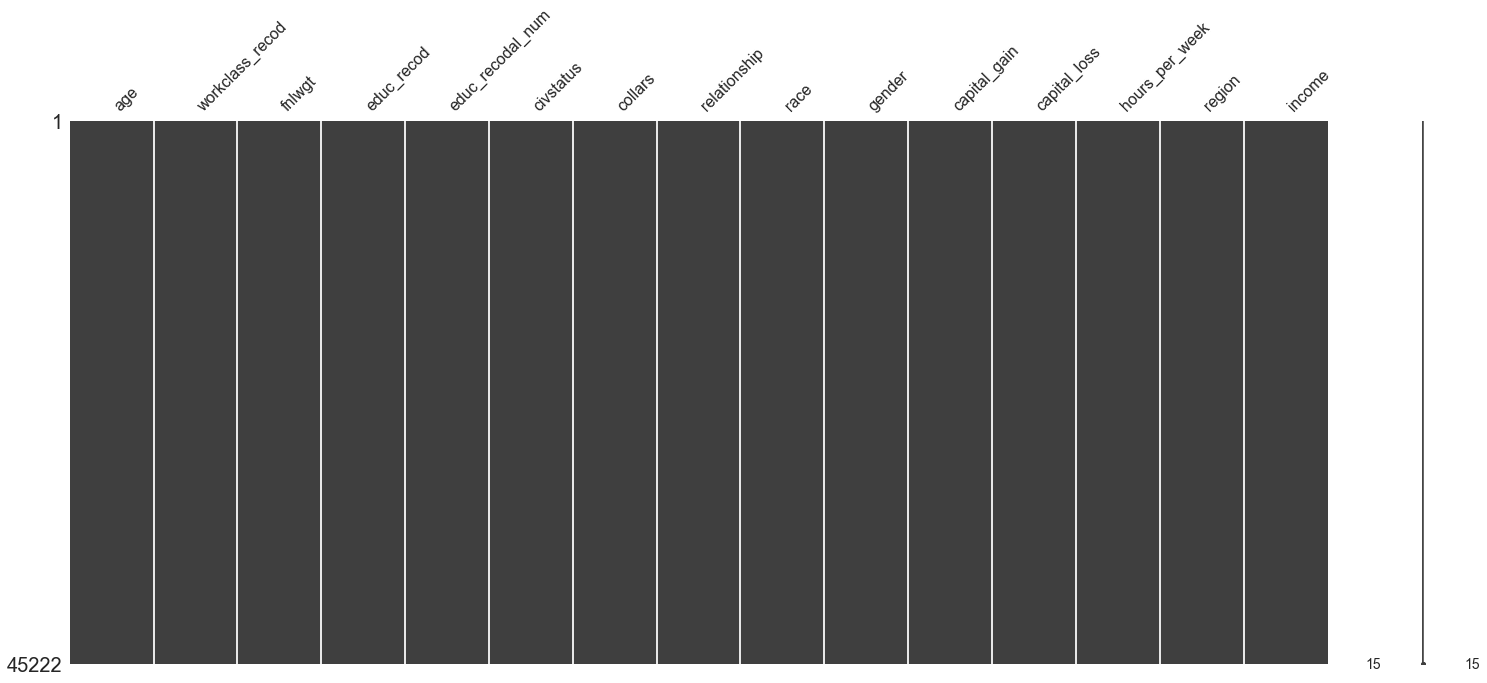

In [42]:
plt.figure(figsize=(4,4))
msngo.matrix(df);

- El dataset no contiene valores perdidos debibo a que en el hito anterior, antes de recodificar las variables se procedió a efectuar la visualización y limpieza de los valores perdidos.

### 2.2.- Estadísticas descriptivas e inspección general de variables

In [43]:
df.dtypes #para obtener el tipo de variables (int son del tipo numérico y object corresponde a string)

age                  int64
workclass_recod     object
fnlwgt               int64
educ_recod          object
educ_recodal_num     int64
civstatus           object
collars             object
relationship        object
race                object
gender              object
capital_gain         int64
capital_loss         int64
hours_per_week       int64
region              object
income              object
dtype: object

In [44]:
# ciclo para obtener las estadísticas descriptivas

for i in df:
    if len(df[i].value_counts()) > 2:
         print(df[i].describe(), "\n")
    else:
        print(df[i].value_counts('%'), "\n") 

count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64 

count       45222
unique          5
top       private
freq        33307
Name: workclass_recod, dtype: object 

count    4.522200e+04
mean     1.897347e+05
std      1.056392e+05
min      1.349200e+04
25%      1.173882e+05
50%      1.783160e+05
75%      2.379260e+05
max      1.490400e+06
Name: fnlwgt, dtype: float64 

count           45222
unique              5
top       high_school
freq            19701
Name: educ_recod, dtype: object 

count    45222.000000
mean        10.118460
std          2.552881
min          1.000000
25%          9.000000
50%         10.000000
75%         13.000000
max         16.000000
Name: educ_recodal_num, dtype: float64 

count       45222
unique          5
top       married
freq        21639
Name: civstatus, dtype: object 

count            45222
unique     

- Se presenta un resumen de las estadísticas descriptivas, cabe fijarse en las diferencias entre las medias y las desviaciones estandart, nos permite visualizar que tan dispersos estarán los datos; en las variables categóricas hay que fijarse en las frecuencias relativas, en el caso de nuestra variable objetivo 'income' podemos observar que un 75% de las muestras corresponde al caso de individuos que perciben un ingreso inferior a 50 k, este sesgo en la muestra podrían afectar la precisión y sensibilidad del modelo de regresión logística.

### 2.3.- Histogramas y gráficos de frecuencias

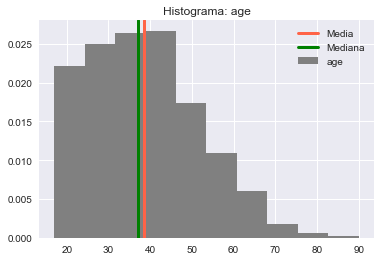

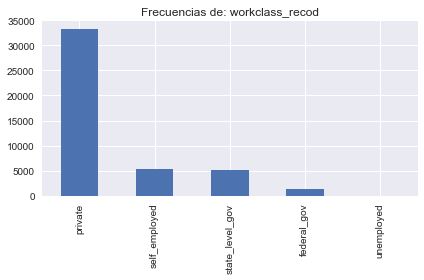

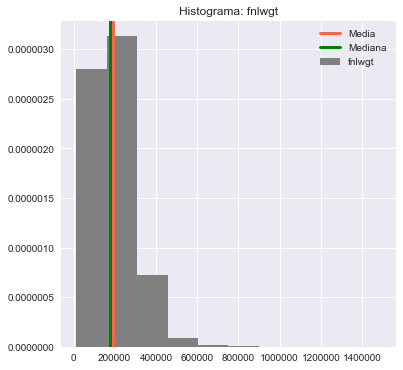

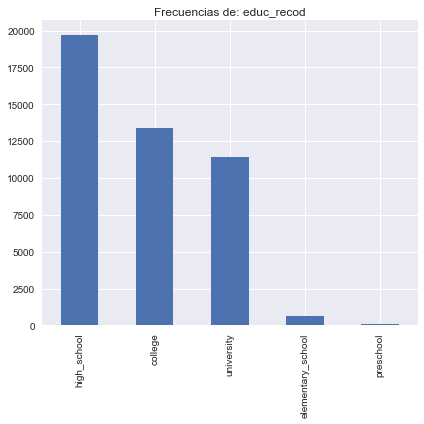

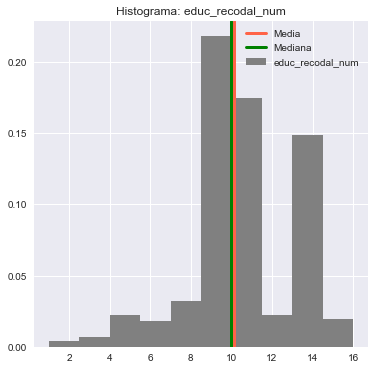

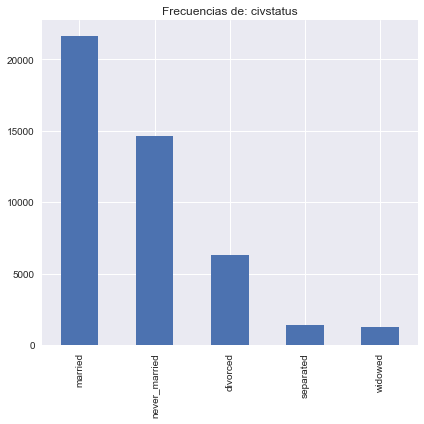

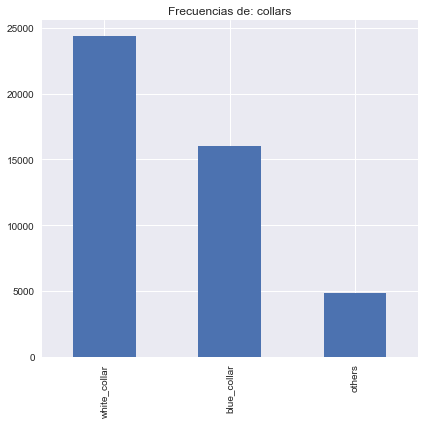

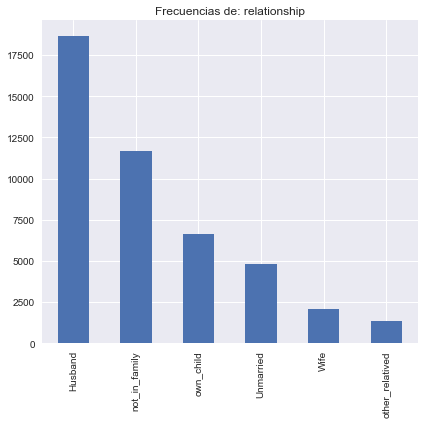

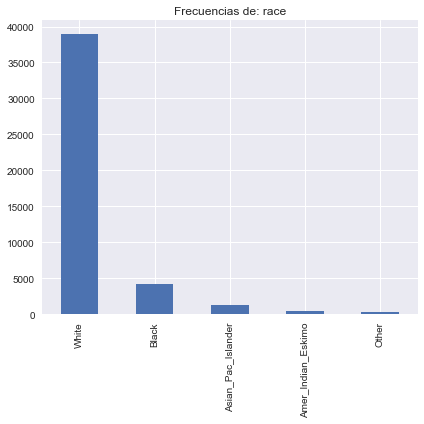

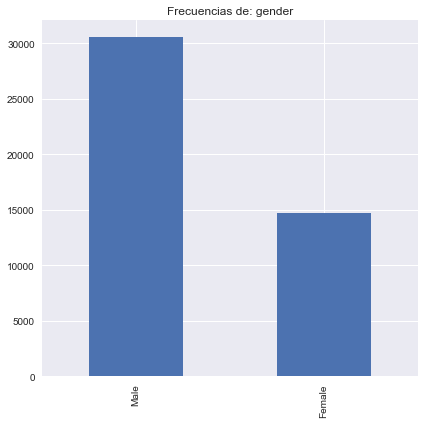

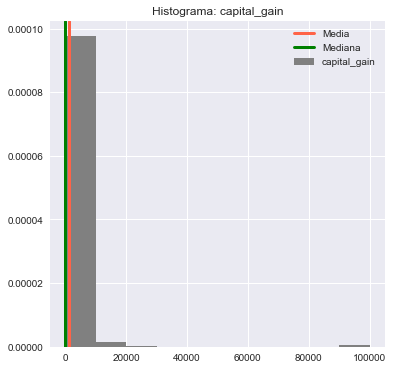

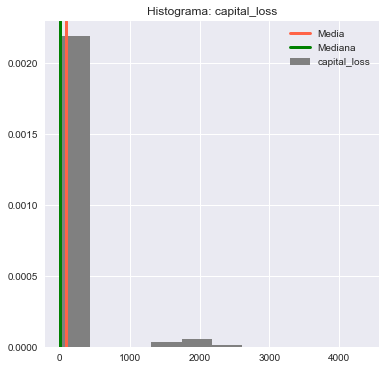

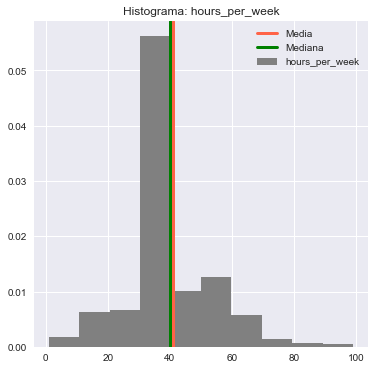

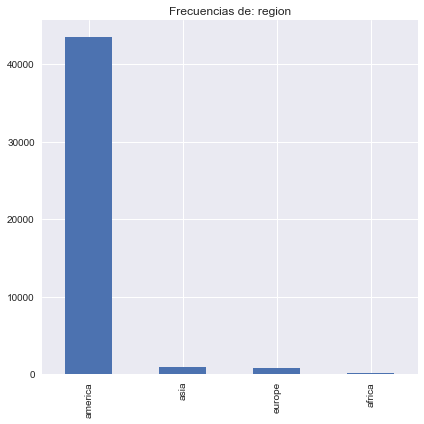

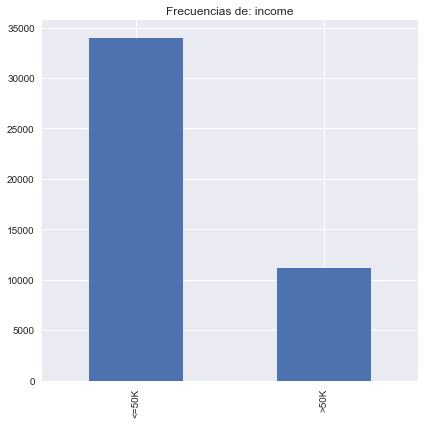

In [45]:
#función para gráficar histogramas en variables numéricas y gráficos de barras de frecuencias en variables categóricas
descriptives_plot(df)

- Los histogramas no se ajustan demasiado a la distribución normal, se puede  apreciar cierto sesgos en las variables y desbalanceos hacia extremos de las distribuciones; los gráficos  de frecuencia también muestran un desbalanceo en el dataset, por ejemplo para regiones 'america' predomina enormente por sobre las otras regiones.

In [46]:
#binarización de 'income'
df['income'].value_counts('%')

<=50K    0.752156
>50K     0.247844
Name: income, dtype: float64

In [47]:
#binarizaremos con MAP
df['income']=df.income.map({'<=50K':0,'>50K':1})

In [48]:
df['income'].value_counts('%')

0    0.752156
1    0.247844
Name: income, dtype: float64

### 2.4.- Análisis visual de la variable objetivo 

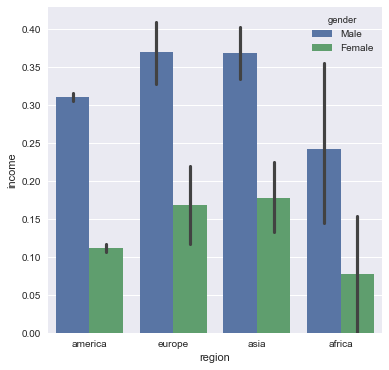

In [49]:
sns.barplot(x="region", y="income", data=df, hue='gender')

- En este gráfico se ve que hay una importante proporción de hombres, casi el doble que las mujeres, en cuanto a percibir ingresos superiores a 50k, la distribución es relativamente similar a nivel de continentes, donde las mayores brechas se observan en América y Africa, aparantemente

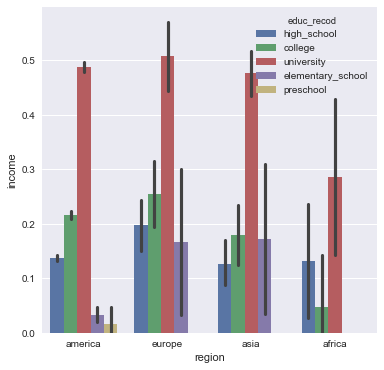

In [50]:
sns.barplot(x="region", y="income", data=df, hue='educ_recod')

- En este gráfico se ve que las personas que van a la Universidad son aquellas que tienen mayor proporción de ingresos sobre 50 k

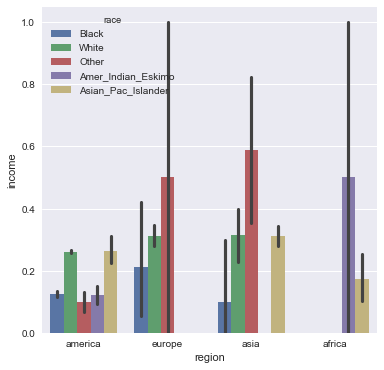

In [51]:
sns.barplot(x="region", y="income", data=df, hue='race')

- En este gráfico se ve la influencia de las razas para el ingreso superior a 50 k, se ve que hay diferencias intercontinentales marcadas, por ejemplo en América los 'blancos' tienen mayor proporción, en Europa y Asia, la raza 'otros' predomina sobre los blancos.

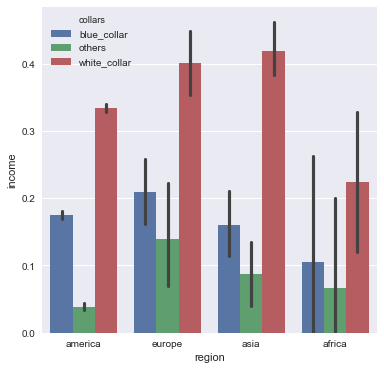

In [52]:
sns.barplot(x="region", y="income", data=df, hue='collars')

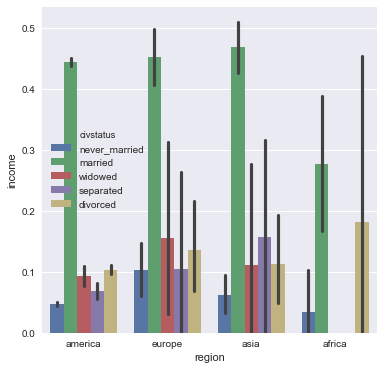

In [53]:
sns.barplot(x="region", y="income", data=df, hue='civstatus')

- Las mayores probabilidades de ingresos sobre 50 k se encuentran en aquellos que están casados, independiente del continente

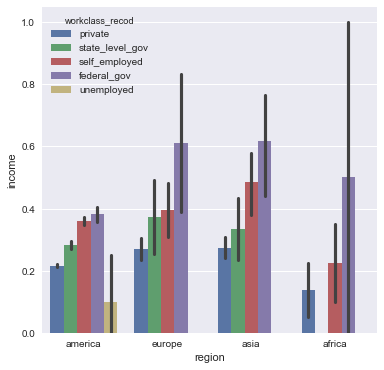

In [54]:
sns.barplot(x="region", y="income", data=df, hue='workclass_recod')

- Se puede apreciar que los empleados del gobierno federal son los que tienden a ganar mayores ingresos, es decir sobre 50k, a nivel mundial, la proporción entre éstos varía continente a continente

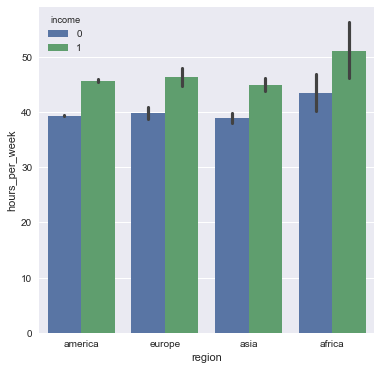

In [55]:
sns.barplot(x="region", y="hours_per_week", data=df, hue='income')

- Se puede observar que no hay demasiada diferencia entre los que trabajan mayor cantidad de horas y perciben ingresos sobre 50k, en apariencia los que reciben ingresos superiores a 50 k, trabajan, en promedio una mayor cantidad de horas, que aquellos que perciben ingresos inferiores a 50 k.

### 2.5.- ScatterPlot

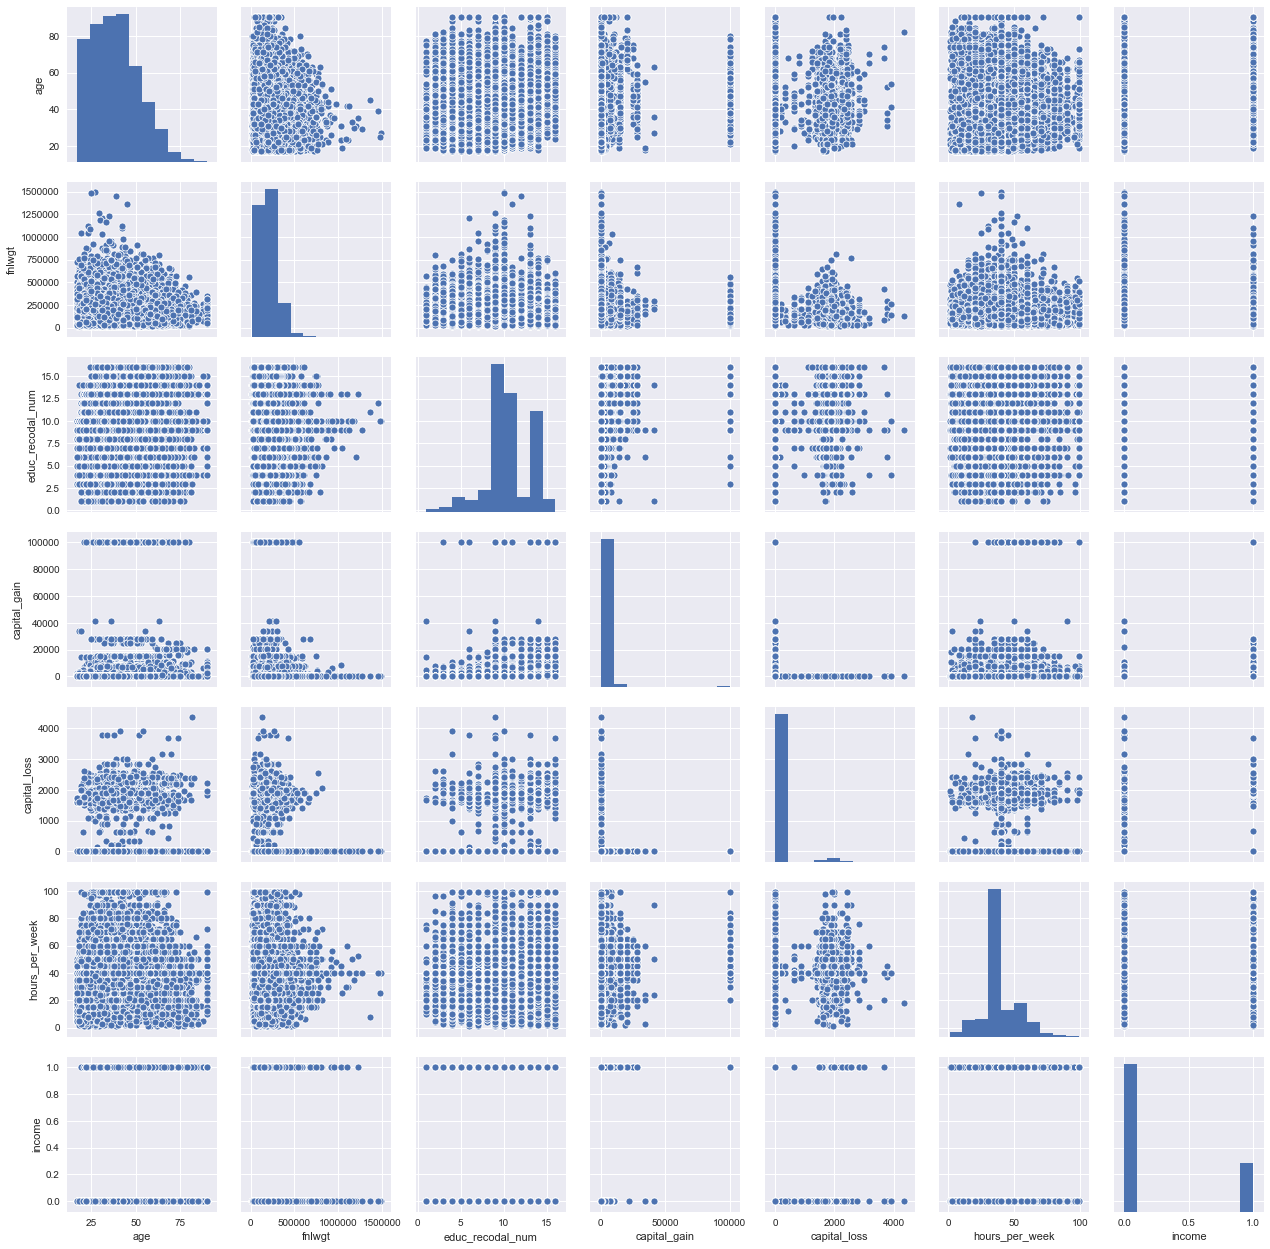

In [56]:

sns.pairplot(df)


- El ScatterPlot muestra las distribuciones de las variables numéricas y categóricas, confrontandolas de manera pareada, sirve para visualizar a nivel general las variables

### 2.6.- Correlaciones y HeatMap

In [57]:
df.corr().style.background_gradient() 

,age,fnlwgt,educ_recodal_num,capital_gain,capital_loss,hours_per_week,income
age,1,-0.075792,0.037623,0.0796832,0.0593506,0.101992,0.23704
fnlwgt,-0.075792,1,-0.041993,-0.00411048,-0.00434878,-0.0186787,-0.00726391
educ_recodal_num,0.037623,-0.041993,1,0.126907,0.0817113,0.146206,0.3328
capital_gain,0.0796832,-0.00411048,0.126907,1,-0.0321023,0.0838804,0.221034
capital_loss,0.0593506,-0.00434878,0.0817113,-0.0321023,1,0.0541949,0.148687
hours_per_week,0.101992,-0.0186787,0.146206,0.0838804,0.0541949,1,0.227199
income,0.23704,-0.00726391,0.3328,0.221034,0.148687,0.227199,1


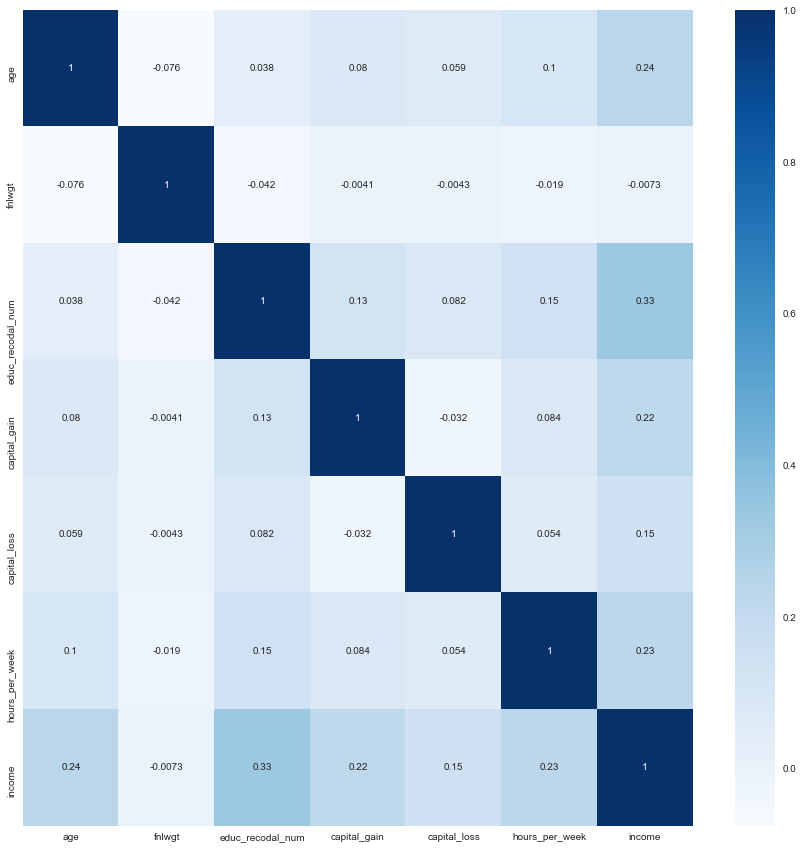

In [58]:
plt.figure(figsize=(15,15)) # aumentamos el tamaño
sns.heatmap(df.corr(), cmap='Blues',annot=True) # mapa de calor de las correlaciones

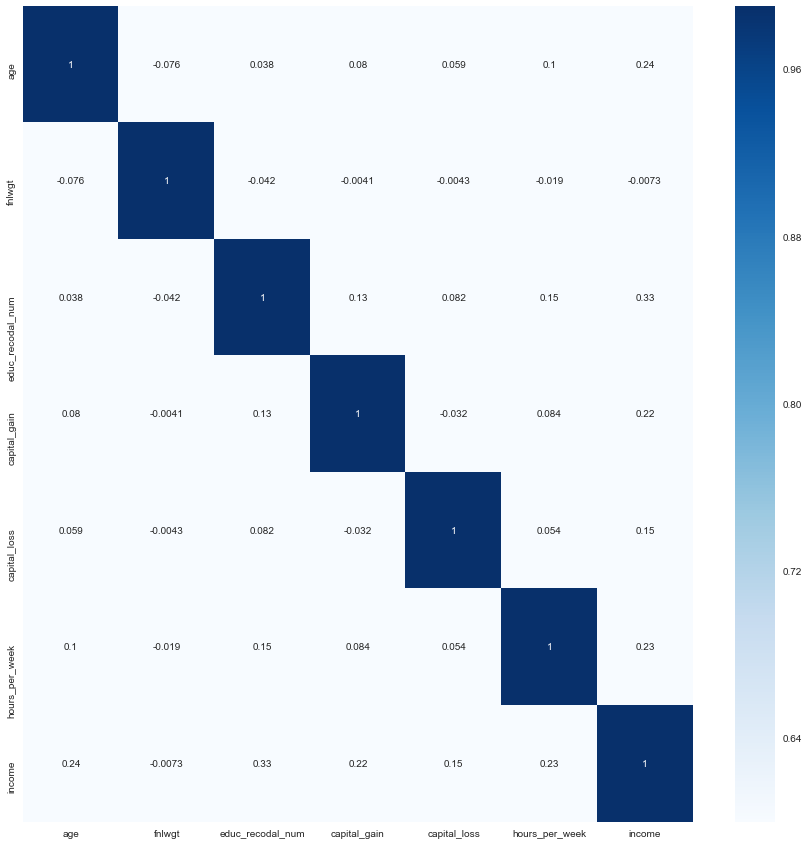

In [59]:
plt.figure(figsize=(15,15)) # aumentamos el tamaño
sns.heatmap(df.corr(), cmap='Blues',vmin=0.6, vmax=0.99, annot=True) # mapa de calor de las correlaciones mayores a 0.6

In [60]:
def corr_means(dataframe, significative=0.5):
    """
    Definición: Función que extrae las correlaciones significativas a un nivel asignado
    
    Input: dataframe a correlacionar, significative (float) de 0 hasta 1.0 que indica el nivel de significancia a filtrar, por 
    defecto viene asignado con un valor superior o igual a 0.5 
    
    Outpout:Imprime las correlaciones positivas y negativas significativas
    """


    names=dataframe.corr().columns.tolist()

    for element in names:
        corr=dataframe.corr()[element].sort_values(ascending=False)
        means_values_positives= pd.Series(corr).where(lambda x  : x>=significative).dropna() 
        means_values_negatives= pd.Series(corr).where(lambda x  : x<=-significative).dropna()


        print("Correlaciones significativas positivas: ",means_values_positives,"\n","\n","Correlaciones significativas negativas: ","\n",means_values_negatives,"\n" )
        
        


In [61]:
corr_means(df)

Correlaciones significativas positivas:  age    1.0
Name: age, dtype: float64 
 
 Correlaciones significativas negativas:  
 Series([], Name: age, dtype: float64) 

Correlaciones significativas positivas:  fnlwgt    1.0
Name: fnlwgt, dtype: float64 
 
 Correlaciones significativas negativas:  
 Series([], Name: fnlwgt, dtype: float64) 

Correlaciones significativas positivas:  educ_recodal_num    1.0
Name: educ_recodal_num, dtype: float64 
 
 Correlaciones significativas negativas:  
 Series([], Name: educ_recodal_num, dtype: float64) 

Correlaciones significativas positivas:  capital_gain    1.0
Name: capital_gain, dtype: float64 
 
 Correlaciones significativas negativas:  
 Series([], Name: capital_gain, dtype: float64) 

Correlaciones significativas positivas:  capital_loss    1.0
Name: capital_loss, dtype: float64 
 
 Correlaciones significativas negativas:  
 Series([], Name: capital_loss, dtype: float64) 

Correlaciones significativas positivas:  hours_per_week    1.0
Name: hour

- Luego de examinar los mapas de correlaciones, se puede afirmar que no se aprecian correlaciones de Pearson lo suficientemente explicativas (r>0.5) entre las variables continuas.

### 2.7.- Pruebas de normalidad variables numéricas

-  Funciones para testear la normalidad  y transformar a log en caso de no calificar como normal

In [113]:
def test_normal_distribution(dataframe, var):
    """
    Definición: Función que permite visualizar histograma de frecuencias, gráficos de residuos, curtosis
    y asimetría para definir si la variable continua pertenece a una distribución normal
    
    Input: recibe un dataframe y una variable numérica. 
    
    Outpout: imprime los gráficos y coeficientes descritos.
    
    
    """
    sns.distplot(dataframe[var], fit = norm);
    plt.figure()
    stats.probplot(dataframe[var], plot = plt)
    plt.figure()
    asimetria=dataframe[var].skew().round(3)
    if asimetria >= -0.6 and asimetria<= 0.6:
        print("El Coeficiente de asimetría tiene un valor de: ", asimetria," lo que significa la curva es simétrica y se aproxima a la normal")
    else:
        print("El coeficiente de asimetría es:", asimetria, " y no se ajusta  a una distribución normal")
    curtosis=dataframe[var].kurt().round(3)
    if curtosis >= -0.6 and curtosis<= 0.6:
        print("El Coeficiente de curtosis tiene un valor de: ", curtosis,"lo que significa la curva es mesocurtica y se aproxima a la normal")
    else:
        print("El coeficiente de curtosis es:",curtosis ," y no se ajusta  a una distribución normal")
    
    




age
El Coeficiente de asimetría tiene un valor de:  0.533  lo que significa la curva es simétrica y se aproxima a la normal
El Coeficiente de curtosis tiene un valor de:  -0.156 lo que significa la curva es mesocurtica y se aproxima a la normal


-------------
fnlwgt
El coeficiente de asimetría es: 1.448  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 6.184  y no se ajusta  a una distribución normal


-------------
hours_per_week
El Coeficiente de asimetría tiene un valor de:  0.341  lo que significa la curva es simétrica y se aproxima a la normal
El coeficiente de curtosis es: 3.201  y no se ajusta  a una distribución normal


-------------
capital_gain
El coeficiente de asimetría es: 11.789  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 150.151  y no se ajusta  a una distribución normal


-------------
capital_loss
El coeficiente de asimetría es: 4.516  y no se ajusta  a una distribución normal
El coeficiente de curtosis es: 19.364

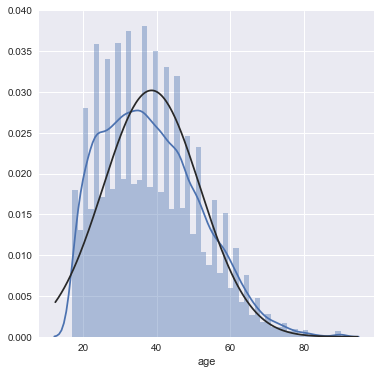

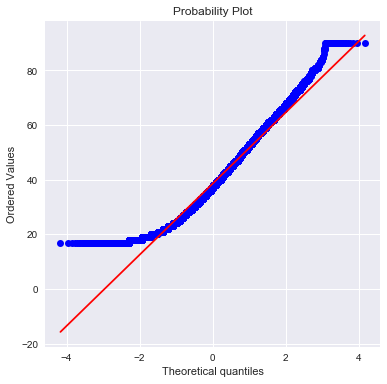

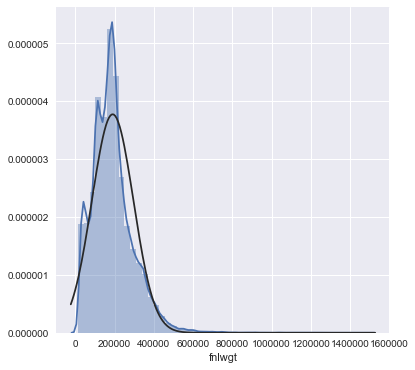

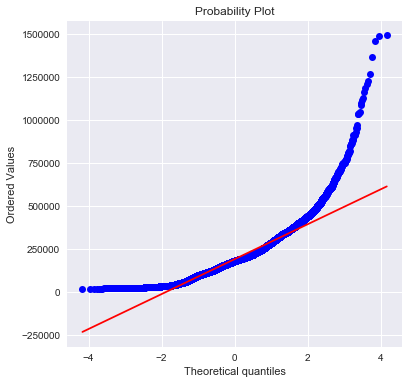

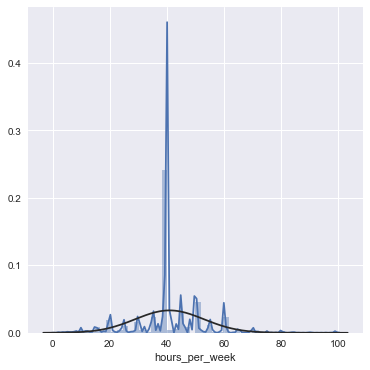

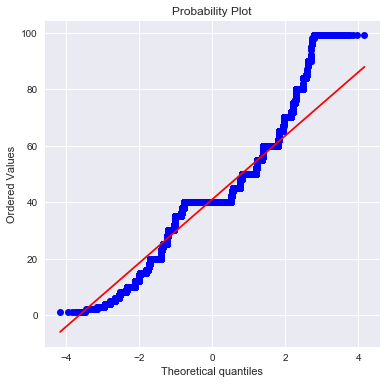

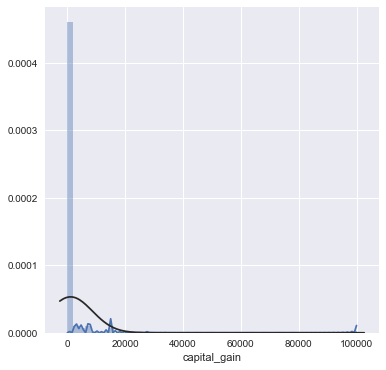

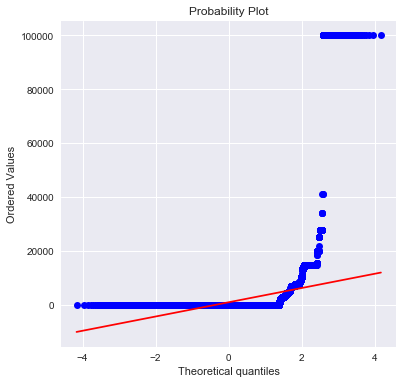

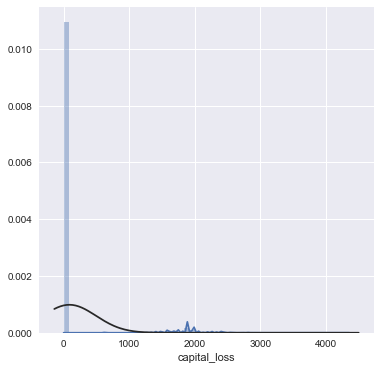

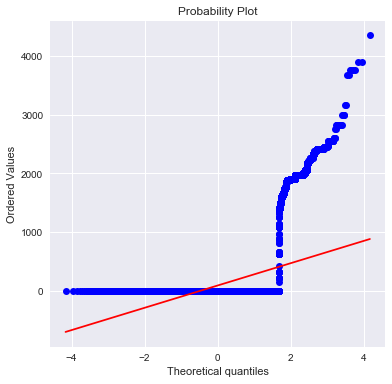

<Figure size 432x432 with 0 Axes>

In [63]:
varnum=['age','fnlwgt','hours_per_week','capital_gain', 'capital_loss']

for i in varnum:
    print(i)
    test_normal_distribution(df,i)
    print('\n')
    print('-------------')

- Los histogramas y gráficos de residuos de las variables continuas, muestran que tanto se ajustan a una distribución normal, si los valores de curtosis y simetría están entre -0.6 a 0.6 se puede decir que se ajusta a una distribución normal mesocutica y simétrica, se aprecia que la mayoría de las variables no se ajusta completamente, por lo que no se descarta la posibilidad de reescalar (logaritmos, otras funciones) en caso de que el modelo no sea lo suficientemente explicativo. 

## Hito 3: Modelación descriptiva
### Nombre: Juan Oyarce G.
### Profesor: Gabriel Tamayo
### Curso: G2

### 3.1 generación de variables dummies

In [64]:
var_categorical=[ 'workclass_recod','educ_recod','civstatus', 'collars', 'relationship', 'race', 'gender','region']

In [65]:
def generate_dummies(dataframe, var):
    
    var_dummies=var+'_dummies'
    var_dummies=pd.get_dummies(dataframe.var, prefix=var, drop_first= True)
    dataframe_mod=dataframe+'_mod'
    dataframe_mod=pd.concat([dataframe,var_dummies], axis=1)
    dataframe_mod.drop(var, axis=1, inplace=True) 
    return(dataframe_mod)

In [66]:
# generación de variables dummies
var_categorical=[ 'workclass_recod','educ_recod','civstatus', 'collars', 'relationship', 'race', 'gender','region']

workclass_recod_dummies=pd.get_dummies(df.workclass_recod,prefix='workclass_recod', drop_first= True) 
df=pd.concat([df,workclass_recod_dummies], axis=1)  
df.drop('workclass_recod', axis=1, inplace=True)  

educ_recod_dummies=pd.get_dummies(df.educ_recod,prefix='educ_recod', drop_first= True) 
df=pd.concat([df,educ_recod_dummies], axis=1)  
df.drop('educ_recod', axis=1, inplace=True) 

civstatus_dummies=pd.get_dummies(df.civstatus,prefix='civstatus', drop_first= True) 
df=pd.concat([df,civstatus_dummies], axis=1)  
df.drop('civstatus', axis=1, inplace=True) 

collars_dummies=pd.get_dummies(df.collars,prefix='collars', drop_first= True) 
df=pd.concat([df,collars_dummies], axis=1)  
df.drop('collars', axis=1, inplace=True) 

relationship_dummies=pd.get_dummies(df.relationship, prefix='relationship', drop_first= True) 
df=pd.concat([df,relationship_dummies], axis=1)  
df.drop('relationship', axis=1, inplace=True) 

race_dummies=pd.get_dummies(df.race, prefix='race', drop_first= True) 
df=pd.concat([df,race_dummies], axis=1)  
df.drop('race', axis=1, inplace=True) 

gender_dummies=pd.get_dummies(df.gender, prefix='gender', drop_first= True) 
df=pd.concat([df,gender_dummies], axis=1)  
df.drop('gender', axis=1, inplace=True) 

region_dummies=pd.get_dummies(df.region, prefix='region', drop_first= True) 
df=pd.concat([df,region_dummies], axis=1)  
df.drop('region', axis=1, inplace=True) 

In [67]:
df.head()

,age,fnlwgt,educ_recodal_num,capital_gain,capital_loss,hours_per_week,income,workclass_recod_private,workclass_recod_self_employed,workclass_recod_state_level_gov,workclass_recod_unemployed,educ_recod_elementary_school,educ_recod_high_school,educ_recod_preschool,educ_recod_university,civstatus_married,civstatus_never_married,civstatus_separated,civstatus_widowed,collars_others,collars_white_collar,relationship_Unmarried,relationship_Wife,relationship_not_in_family,relationship_other_relatived,relationship_own_child,race_Asian_Pac_Islander,race_Black,race_Other,race_White,gender_Male,region_america,region_asia,region_europe
0,25,226802,7,0,0,40,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0
1,38,89814,9,0,0,50,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
2,28,336951,12,0,0,40,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
3,44,160323,10,7688,0,40,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
5,34,198693,6,0,0,30,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0


### 3.2 Modelación inicial (Modelo saturado)

In [70]:
variables= list(df.columns)
variables.remove('income')
variables

['age',
 'fnlwgt',
 'educ_recodal_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'workclass_recod_private',
 'workclass_recod_self_employed',
 'workclass_recod_state_level_gov',
 'workclass_recod_unemployed',
 'educ_recod_elementary_school',
 'educ_recod_high_school',
 'educ_recod_preschool',
 'educ_recod_university',
 'civstatus_married',
 'civstatus_never_married',
 'civstatus_separated',
 'civstatus_widowed',
 'collars_others',
 'collars_white_collar',
 'relationship_Unmarried',
 'relationship_Wife',
 'relationship_not_in_family',
 'relationship_other_relatived',
 'relationship_own_child',
 'race_Asian_Pac_Islander',
 'race_Black',
 'race_Other',
 'race_White',
 'gender_Male',
 'region_america',
 'region_asia',
 'region_europe']

In [71]:
var=' + '.join(variables) 
m1_logit = smf.logit('income ~'+ var , df).fit()
m1_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.331554
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                    Logit                 Pseudo R-squared:      0.408     
Dependent Variable:       income                AIC:                   30055.0697
Date:                     2019-07-26 22:57      BIC:                   30351.5272
No. Observations:         45222                 Log-Likelihood:        -14994.   
Df Model:                 33                    LL-Null:               -25322.   
Df Residuals:             45188                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           11.0000                                                
---------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                       -9.2291   0.4947 -18.6542 0.0000 -10.1988 -8.2594
age                              0.0253   0.0014  18.6814 0.0000   0.0226  0.0279
fnlwgt                           0.0000   0.0000   5.2500 0.0000   0.0000  0.0000
educ_recodal_num                 0.2765   0.0160  17.2394 0.0000   0.2450  0.3079
capital_gain                     0.0003   0.0000  36.8906 0.0000   0.0003  0.0003
capital_loss                     0.0007   0.0000  21.3268 0.0000   0.0006  0.0007
hours_per_week                   0.0298   0.0013  22.5251 0.0000   0.0272  0.0323
workclass_recod_private         -0.4448   0.0750  -5.9305 0.0000  -0.5919 -0.2978
workclass_recod_self_employed   -0.7828   0.0821  -9.5315 0.0000  -0.9437 -0.6218
workclass_recod_state_level_gov -0.5194   0.0837  -6.2023 0.0000  -0.6835 -0.3553
workclass_recod_unemployed      -1.5507   0.8030  -1.9311 0.0535  -3.1246  0.0232
educ_recod_elementary_school     0.1402   0.2372   0.5911 0.5544  -0.3247  0.6052
educ_recod_high_school          -0.0647   0.0468  -1.3843 0.1663  -0.1563  0.0269
educ_recod_preschool            -3.9750   4.0438  -0.9830 0.3256 -11.9006  3.9507
educ_recod_university            0.0884   0.0608   1.4537 0.1460  -0.0308  0.2075
civstatus_married                0.8013   0.1384   5.7892 0.0000   0.5300  1.0726
civstatus_never_married         -0.4874   0.0722  -6.7469 0.0000  -0.6290 -0.3458
civstatus_separated             -0.0312   0.1331  -0.2344 0.8147  -0.2921  0.2297
civstatus_widowed                0.0901   0.1280   0.7038 0.4816  -0.1608  0.3409
collars_others                  -0.7292   0.0869  -8.3889 0.0000  -0.8996 -0.5588
collars_white_collar             0.6023   0.0354  17.0253 0.0000   0.5329  0.6716
relationship_Unmarried          -1.1948   0.1505  -7.9412 0.0000  -1.4896 -0.8999
relationship_Wife                1.0611   0.0841  12.6104 0.0000   0.8962  1.2260
relationship_not_in_family      -0.9647   0.1339  -7.2034 0.0000  -1.2272 -0.7022
relationship_other_relatived    -1.4237   0.1871  -7.6080 0.0000  -1.7905 -1.0569
relationship_own_child          -1.9445   0.1664 -11.6873 0.0000  -2.2706 -1.6184
race_Asian_Pac_Islander          0.8228   0.2231   3.6878 0.0002   0.3855  1.2601
race_Black                       0.2631   0.1891   1.3913 0.1641  -0.1075  0.6337
race_Other                       0.2363   0.2720   0.8687 0.3850  -0.2969  0.7695
race_White                       0.5067   0.1797   2.8198 0.0048   0.1545  0.8588
gender_Male                      0.7803   0.0643  12.1376 0.0000   0.6543  0.9063
region_america                   1.4708   0.3815   3.8552 0.0001   0.7230  2.2185
region_asia                      1.0205   0.3707   2.7527 0.0059   0.2939  1.7471
region_europe                    1.6736   0.3953   4.2336 0.0000   0.8988  2.4484
=================================================================================

"""

In [72]:
# Extraemos las variables cuyos p-values son estadisticamente significativos
pvalues = m1_logit.pvalues
print ('Las siguientes variables son estadísticamente significativas: ')        
means_values= pd.Series(pvalues).where(lambda x : x<0.05).dropna() 
print(means_values)

Las siguientes variables son estadísticamente significativas: 
Intercept                           1.168374e-77
age                                 7.019379e-78
fnlwgt                              1.520991e-07
educ_recodal_num                    1.343751e-66
capital_gain                       6.533860e-298
capital_loss                       6.401947e-101
hours_per_week                     2.357512e-112
workclass_recod_private             3.019622e-09
workclass_recod_self_employed       1.550050e-21
workclass_recod_state_level_gov     5.564221e-10
civstatus_married                   7.071588e-09
civstatus_never_married             1.510395e-11
collars_others                      4.908884e-17
collars_white_collar                5.331775e-65
relationship_Unmarried              2.002930e-15
relationship_Wife                   1.850712e-36
relationship_not_in_family          5.874048e-13
relationship_other_relatived        2.783627e-14
relationship_own_child              1.479572e-31
race_A

In [74]:
def invlogit(x):
    return 1 / (1+np.exp(-x))

In [75]:
# variables numéricas

variables= list(means_values.index)
variables.remove('Intercept')
for var in variables:
    estimate_y = m1_logit.params['Intercept'] + (m1_logit.params[var] * df[var].mean())
    print("El log odds estimado para ", var, " es de ", round(estimate_y, 3))
    
print("La probabilidad de que el valor más frecuente o medio de la variable: ",var,"incida en salarios superiores a 50 K es ",round(invlogit(estimate_y), 2))

El log odds estimado para  age  es de  -8.254
El log odds estimado para  fnlwgt  es de  -9.09
El log odds estimado para  educ_recodal_num  es de  -6.432
El log odds estimado para  capital_gain  es de  -8.879
El log odds estimado para  capital_loss  es de  -9.171
El log odds estimado para  hours_per_week  es de  -8.011
El log odds estimado para  workclass_recod_private  es de  -9.557
El log odds estimado para  workclass_recod_self_employed  es de  -9.323
El log odds estimado para  workclass_recod_state_level_gov  es de  -9.287
El log odds estimado para  civstatus_married  es de  -8.846
El log odds estimado para  civstatus_never_married  es de  -9.386
El log odds estimado para  collars_others  es de  -9.307
El log odds estimado para  collars_white_collar  es de  -8.905
El log odds estimado para  relationship_Unmarried  es de  -9.356
El log odds estimado para  relationship_Wife  es de  -9.18
El log odds estimado para  relationship_not_in_family  es de  -9.479
El log odds estimado para  re

- Se puede apreciar que odds estimados son  bajos, si se toman los valores medios de las variables, se puede indagar que tanto explica el modelo, a continuación se transforman en probabilidades

### 3.3 Obtención de probabilidades

In [76]:
variables= list(means_values.index)
variables.remove('Intercept')
for var in variables:
    estimate_y = m1_logit.params['Intercept'] + (m1_logit.params[var] * df[var].mean())
    print("El log odds estimado para ", var, " es de ", round(estimate_y, 3))
    print("La probabilidad de que el valor más frecuente o medio de la variable: ",var,"incida en salarios superiores a 50 K es ",round(invlogit(estimate_y), 3))
    print("\n")


El log odds estimado para  age  es de  -8.254
La probabilidad de que el valor más frecuente o medio de la variable:  age incida en salarios superiores a 50 K es  0.0


El log odds estimado para  fnlwgt  es de  -9.09
La probabilidad de que el valor más frecuente o medio de la variable:  fnlwgt incida en salarios superiores a 50 K es  0.0


El log odds estimado para  educ_recodal_num  es de  -6.432
La probabilidad de que el valor más frecuente o medio de la variable:  educ_recodal_num incida en salarios superiores a 50 K es  0.002


El log odds estimado para  capital_gain  es de  -8.879
La probabilidad de que el valor más frecuente o medio de la variable:  capital_gain incida en salarios superiores a 50 K es  0.0


El log odds estimado para  capital_loss  es de  -9.171
La probabilidad de que el valor más frecuente o medio de la variable:  capital_loss incida en salarios superiores a 50 K es  0.0


El log odds estimado para  hours_per_week  es de  -8.011
La probabilidad de que el valor má

- Las probabilidades no son significativas para un caso medio con variables continuas, por lo que se procederá a depurar el modelo.

### 3.4 Refactorización con valores estadísticamente significativos (modelo depurado)

In [77]:
# generamos un modelo depurado con variables estadísticamente significativas

variables= list(means_values.index)
variables.remove('Intercept') # Removemos el Intercepto
var=' + '.join(variables)
mr_logit = smf.logit('income ~ '+ var, df).fit()
mr_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.331725
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Logit
=================================================================================
Model:                    Logit                 Pseudo R-squared:      0.408     
Dependent Variable:       income                AIC:                   30052.5407
Date:                     2019-07-26 22:59      BIC:                   30270.5242
No. Observations:         45222                 Log-Likelihood:        -15001.   
Df Model:                 24                    LL-Null:               -25322.   
Df Residuals:             45197                 LLR p-value:           0.0000    
Converged:                1.0000                Scale:                 1.0000    
No. Iterations:           9.0000                                                 
---------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
---------------------------------------------------------------------------------
Intercept                       -9.2596   0.4387 -21.1084 0.0000 -10.1194 -8.3999
age                              0.0255   0.0013  19.0610 0.0000   0.0228  0.0281
fnlwgt                           0.0000   0.0000   5.4303 0.0000   0.0000  0.0000
educ_recodal_num                 0.2997   0.0073  41.1899 0.0000   0.2854  0.3139
capital_gain                     0.0003   0.0000  36.8901 0.0000   0.0003  0.0003
capital_loss                     0.0007   0.0000  21.3581 0.0000   0.0006  0.0007
hours_per_week                   0.0297   0.0013  22.5168 0.0000   0.0271  0.0323
workclass_recod_private         -0.4239   0.0744  -5.6959 0.0000  -0.5697 -0.2780
workclass_recod_self_employed   -0.7633   0.0816  -9.3594 0.0000  -0.9232 -0.6035
workclass_recod_state_level_gov -0.4974   0.0832  -5.9802 0.0000  -0.6604 -0.3344
civstatus_married                0.7935   0.1360   5.8351 0.0000   0.5270  1.0601
civstatus_never_married         -0.4864   0.0684  -7.1086 0.0000  -0.6205 -0.3523
collars_others                  -0.7249   0.0869  -8.3390 0.0000  -0.8953 -0.5545
collars_white_collar             0.6121   0.0351  17.4600 0.0000   0.5434  0.6808
relationship_Unmarried          -1.1979   0.1502  -7.9744 0.0000  -1.4923 -0.9035
relationship_Wife                1.0516   0.0838  12.5484 0.0000   0.8874  1.2159
relationship_not_in_family      -0.9676   0.1337  -7.2362 0.0000  -1.2297 -0.7055
relationship_other_relatived    -1.4254   0.1872  -7.6140 0.0000  -1.7923 -1.0585
relationship_own_child          -1.9506   0.1660 -11.7476 0.0000  -2.2761 -1.6252
race_Asian_Pac_Islander          0.5904   0.1443   4.0925 0.0000   0.3076  0.8731
race_White                       0.2712   0.0576   4.7063 0.0000   0.1583  0.3841
gender_Male                      0.7759   0.0638  12.1552 0.0000   0.6508  0.9010
region_america                   1.4688   0.3812   3.8530 0.0001   0.7217  2.2160
region_asia                      1.0180   0.3705   2.7476 0.0060   0.2918  1.7442
region_europe                    1.6798   0.3951   4.2518 0.0000   0.9054  2.4541
=================================================================================

"""

- El modelo depurado baja de 33 a 24 variables,  los valores de los coeficientes no son muy altos y hay varias variables que tienen una significancia negativa, ésto se correlaciona con lo observado en la inspección visual

## Hito 4: Modelación predictiva
### Nombre: Juan Oyarce G.
### Profesor: Gabriel Tamayo
### Curso: G2

### 4.1 Estandarización de  la matriz de atributos 

In [78]:
variables= list(means_values.index)
variables.remove('Intercept') # Removemos el Intercepto
atributos = variables  #matriz de atributos
target = ["income"]    #vector objetivo


scalar_model = StandardScaler().fit(df.loc[:,atributos])  #parametros para escalar las variables y estandarizarlas
X = scalar_model.transform(df.loc[:,atributos]) 

### 4.2 Generación de subconjuntos de entrenamiento y validación, separando el 33% de la muestra en el conjunto de validación 

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   df.loc[:,target],
                                                   test_size = .33,
                                                   random_state=11238)

### 4.3 Implementación de los modelos

In [80]:
#Modelo con Intercepto y sin balancear
default_model = LogisticRegression().fit(X_train, y_train)

In [81]:
# Modelo con Intercepto y Balanceado
model_trained_2 = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

In [82]:
### Modelo sin Intercepto y  Balanceado
model_trained_3 = LogisticRegression(fit_intercept=False, class_weight='balanced').fit(X_train, y_train)

In [83]:
default_model.coef_

array([[ 0.3450267 ,  0.06632404,  0.78518745,  2.34591992,  0.26069322,
         0.32085261, -0.13359558, -0.21922742, -0.13033864,  0.44985478,
        -0.23020922, -0.20318961,  0.3044377 , -0.37956743,  0.20232356,
        -0.36838189, -0.21260622, -0.62571824,  0.06690374,  0.07874619,
         0.34631223,  0.28528202,  0.15752497,  0.20413033]])

In [84]:
model_trained_2.coef_

array([[ 0.40019834,  0.05644435,  0.79915502,  2.33931198,  0.25996868,
         0.37835798, -0.13428451, -0.20618372, -0.12500645,  0.53141306,
        -0.21731779, -0.19474934,  0.29449227, -0.34391077,  0.21775645,
        -0.31277391, -0.19784497, -0.57742811,  0.0836323 ,  0.08506629,
         0.35123066,  0.24564592,  0.13124303,  0.19076401]])

In [85]:
model_trained_3.coef_

array([[ 0.3378854 ,  0.05708047,  0.71784628,  4.22036156,  0.25928525,
         0.31915498, -0.12662259, -0.18854999, -0.12488978,  0.38727378,
        -0.12977374, -0.06996451,  0.2964087 , -0.36620099,  0.16619459,
        -0.42853236, -0.18290376, -0.43185111,  0.06633498,  0.07472197,
         0.27186831,  0.19592575,  0.10853761,  0.14947569]])

In [86]:
default_model.intercept_

array([-1.87128674])

In [87]:
model_trained_2.intercept_

array([-0.79177503])

In [88]:
model_trained_3.intercept_

0.0

### 4.4 Generación de  predicción de las clases y de la probabilidad

In [89]:
# Predicciones de Clase

y_pred = default_model.predict(X_test)
# solicitemos las primeras 10 observaciones del vector predicho.
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [90]:
y_pred_2 = model_trained_2.predict(X_test)
# solicitemos las primeras 10 observaciones del vector predicho.
y_pred_2[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int64)

In [91]:
y_pred_3 = model_trained_3.predict(X_test)
# solicitemos las primeras 10 observaciones del vector predicho.
y_pred_3[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int64)

In [92]:
# Predicciones de Probabilidad

y_pred_prob = default_model.predict_proba(X_test).round(3)
y_pred_prob[:10]

array([[0.992, 0.008],
       [0.995, 0.005],
       [0.997, 0.003],
       [0.936, 0.064],
       [0.998, 0.002],
       [0.991, 0.009],
       [0.226, 0.774],
       [0.988, 0.012],
       [0.629, 0.371],
       [0.597, 0.403]])

In [93]:
# Predicciones de Probabilidad

y_pred_prob = model_trained_2.predict_proba(X_test).round(3)
y_pred_prob[:10]

array([[0.977, 0.023],
       [0.987, 0.013],
       [0.993, 0.007],
       [0.841, 0.159],
       [0.996, 0.004],
       [0.973, 0.027],
       [0.087, 0.913],
       [0.967, 0.033],
       [0.361, 0.639],
       [0.29 , 0.71 ]])

In [94]:
# Predicciones de Probabilidad

y_pred_prob = model_trained_3.predict_proba(X_test).round(3)
y_pred_prob[:10]

array([[0.96 , 0.04 ],
       [0.972, 0.028],
       [0.978, 0.022],
       [0.75 , 0.25 ],
       [0.981, 0.019],
       [0.931, 0.069],
       [0.082, 0.918],
       [0.935, 0.065],
       [0.311, 0.689],
       [0.272, 0.728]])

### 4.5 Reporte las métricas de precision, recall y f1 para ambas clases 

In [95]:
# matriz de confusión
#Modelo con Intercepto y sin balancear
m_confusion = confusion_matrix(y_test, y_pred)
m_confusion


array([[10384,   806],
       [ 1559,  2175]], dtype=int64)

In [96]:
# matriz de confusión
# Modelo con Intercepto y Balanceado
m_confusion = confusion_matrix(y_test, y_pred_2)
m_confusion

array([[8862, 2328],
       [ 591, 3143]], dtype=int64)

In [97]:
# matriz de confusión
# Modelo sin Intercepto y Balanceado

m_confusion = confusion_matrix(y_test, y_pred_3)
m_confusion

array([[8255, 2935],
       [ 413, 3321]], dtype=int64)

In [98]:
# Precisión del Modelo sin Intercepto y sin balancear
precision_score(y_test, y_pred)


0.7296209325729621

In [99]:
# Precisión del Modelo con Intercepto y Balanceado
precision_score(y_test, y_pred_2)

0.5744836410162676

In [100]:
# Precisión del Modelo sin Intercepto y Balanceado
precision_score(y_test, y_pred_3)

0.5308503836317136

In [101]:
# resumen de las métricas Modelo sin Intercepto y sin balancear

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     11190
           1       0.73      0.58      0.65      3734

   micro avg       0.84      0.84      0.84     14924
   macro avg       0.80      0.76      0.77     14924
weighted avg       0.83      0.84      0.84     14924



In [102]:
# resumen de las métricas Modelo con Intercepto y balanceado
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     11190
           1       0.57      0.84      0.68      3734

   micro avg       0.80      0.80      0.80     14924
   macro avg       0.76      0.82      0.77     14924
weighted avg       0.85      0.80      0.81     14924



In [103]:
# resumen de las métricas Modelo sin Intercepto y balanceado
print(classification_report(y_test,y_pred_3))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83     11190
           1       0.53      0.89      0.66      3734

   micro avg       0.78      0.78      0.78     14924
   macro avg       0.74      0.81      0.75     14924
weighted avg       0.85      0.78      0.79     14924



- Se puede apreciar que las métricas de desempeño para los modelos son relativamente similares, para el caso del modelo sin intercepto y sin balancear, tiene un mejor coeficiente de precisión (0.73) para los casos verdaderos, éste modelo tiene mayor precisión porque clasifica mejor ambos casos de clasificación, es decir aquellos que reciben más de 50 k y menos ingresos de 50 k, si bien la tendencia es que todos los modelos tienden a estimar mejor aquellos que perciben ingresos inferiores a 50 k, ésto es debido a que el dataset está desbalanceado ya que el 75 % de la muestra corresponde a aquellos casos. 

### 4.6 Curvas Receiver Operator Characteristic (ROC)

In [104]:
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = default_model.predict_proba(X_test)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)

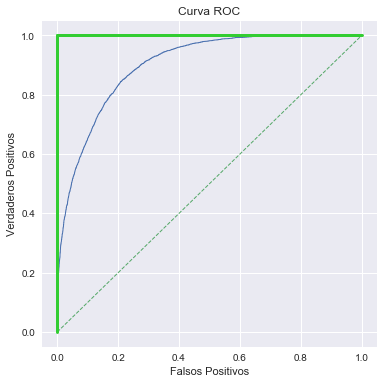

In [105]:
# Gráfica curva ROC
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [106]:
# COEFICIENTE DE DESEMPEÑO ROC DEL MODELO

roc_auc_score(y_test, yhat)

0.9007110708399926

In [107]:
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = model_trained_2.predict_proba(X_test)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)

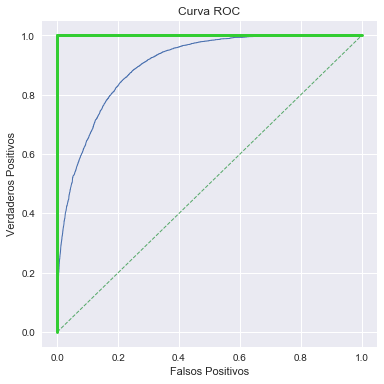

In [108]:
# Gráfica curva ROC
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [109]:
roc_auc_score(y_test, yhat)

0.9009802922017467

In [110]:
# reestimamos los valores predichos de nuestro modelo para obtener la probabilidad entre 0 y 1.
yhat = model_trained_3.predict_proba(X_test)[:, 1]
# generamos los objetos de roc_cruve
false_positive, true_positive, threshold = roc_curve(y_test, yhat)

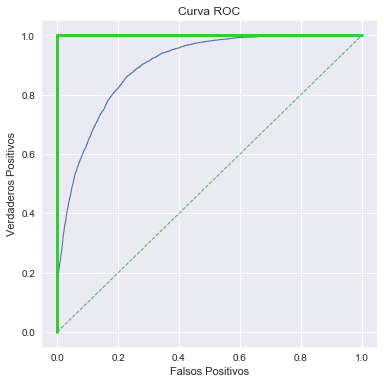

In [111]:
# Gráfica curva ROC
plt.title('Curva ROC')
plt.plot(false_positive, true_positive, lw=1)
plt.plot([0, 1], ls="--", lw=1)
plt.plot([0, 0], [1, 0] , c='limegreen', lw=3), plt.plot([1, 1] , c='limegreen', lw=3)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos');

In [112]:
roc_auc_score(y_test, yhat)

0.8973170723535102

- Los 3 modelos tienen coeficientes ROC cercanos a 0.9, lo que indica la curva que son buenos generando clasificaciones, ya que están muy por encima del valor de clasificación aleatorio (0.5), pero dado las métricas anteriores de precisión, recall, F1, en conjunto el primer modelo puede clasificar mejor ambos casos.